# Exploratory data analysis of the Steam dataset

Dataset from: https://www.kaggle.com/tamber/steam-video-games

### Dataset description (from the dataset author):
Steam is the world's most popular PC Gaming hub. With a massive collection that includes everything from AAA blockbusters to small indie titles, great discovery tools can be super valuable for Steam. How can we make them better?

This dataset is a list of user behaviors, with columns: user-id, game-title, behavior-name, value. The behaviors included are 'purchase' and 'play'. The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.

### Basic modifications

The value for the `purchase` is always 1. Since it is redundant we can delete all `purchase`, and therefore the `behavior-name` column as well. We will call `value`, `playtime` instead. 

In [2]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from time import time
import contextlib

@contextlib.contextmanager
def timer(msg):
    tic = time()
    yield
    print(msg + ": %.2f s" % (time() - tic))

In [16]:
# Load

df = pd.read_csv("./Data/Steam/steam-200k.csv",
                 usecols = [0,1,2,3],
                 names=['user-id', 'game', 'behavior-name', 'playtime'],nrows=10000)
df.drop(np.argwhere((df['behavior-name']=='purchase').values)[:,0], axis=0, inplace=True)
df.drop('behavior-name',axis=1,inplace=True)

In [17]:
df.head()

,user-id,game,playtime
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3552 entries, 1 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user-id   3552 non-null   int64  
 1   game      3552 non-null   object 
 2   playtime  3552 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 111.0+ KB


In [19]:
print(f"# unique user: {df['user-id'].nunique()}")
print(f"# unique games: {df['game'].nunique()}")

# unique user: 516
# unique games: 1141


# Data preparation

First, I create new dataframes to store data information about games, users and the relation between game and user. Here are the details of these dataframes:

- game dataframe: `game_df`
    - number purchases
    - min, max, mean, 25,50,75 percentile of play time
- user dataframe: `user_df`
    - number of games owned
    - total playtime
    - min, max, mean, 25,50,75 percentile of playtime across all games owned
- sparse matrix that links game and user with playtime: `playtime_df`
    - row=user, column=game
    - value = playtime, 0=not owned or not played
- sparse matrix that links game and user with a score: `score_df`
    - row=user, column=game
    - s=0: that user does not own that game (note: may need to include games owned but not played)
    - s=1-4:
        - 1: this user playtime on that game <25 percentile of playtime for that game
        - 2: 25-50%
        - 3: 50:75%
        - 4: >75%
        
## Data cleaning

The dataset is pretty big, but contains a lot of: 
    - users who played only one game for a short amount of time
    - games played by only one user for a short amount of time

Will filter these out to remove the dimensionality and keep the most informative data.

In [20]:
# Create playtime_df
user_list = df['user-id'].unique()
game_list = df['game'].unique()

playtime_df = pd.DataFrame(np.zeros((len(user_list),len(game_list))),
                           index = user_list,
                           columns = game_list)


for user in user_list:
    game_list = df.loc[df['user-id']==user,'game']
    playtime_list = df.loc[df['user-id']==user,'playtime']
    for game, playtime in zip(game_list,playtime_list):
        playtime_df.loc[user,game] = playtime
    

Before filtering: # users: 516, games: 1141
After filtering: # users: 354, games: 649


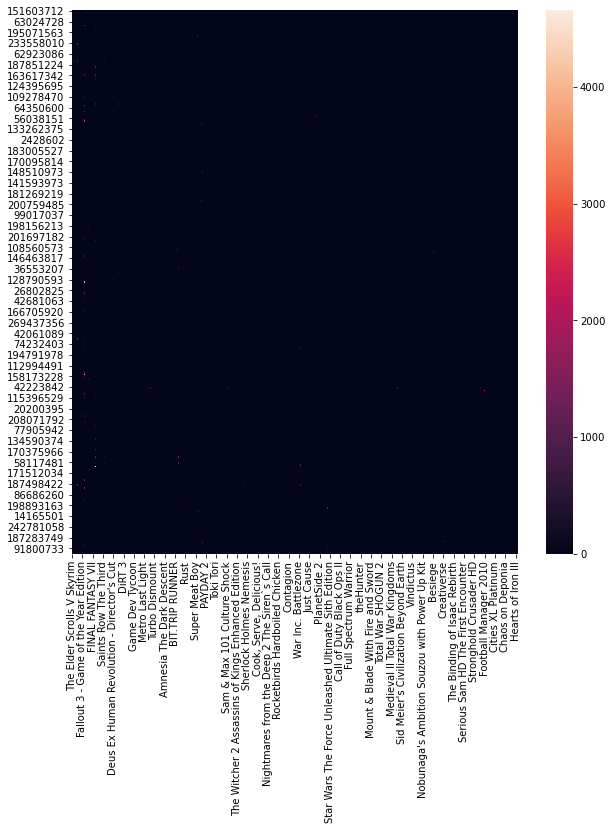

In [21]:
# Apply filters
game_playtime_thr = 5.0
user_playtime_thr = 5.0

drop_game_list = []
drop_user_list = []

for game in playtime_df.columns:
    playtime_total = playtime_df[game].sum()
    if playtime_total<game_playtime_thr:
        drop_game_list.append(game)

        
for user in playtime_df.index:
    playtime_total = playtime_df.loc[user].sum()
    if playtime_total<user_playtime_thr:
        drop_user_list.append(user) 

print(f"Before filtering: # users: {playtime_df.shape[0]}, games: {playtime_df.shape[1]}")        
# Apply filter
# ==============
playtime_df.drop(index=drop_user_list,columns=drop_game_list,inplace=True)
print(f"After filtering: # users: {playtime_df.shape[0]}, games: {playtime_df.shape[1]}")        

fig, ax = plt.subplots(1,1,figsize=[10,10])
_ = sns.heatmap(playtime_df)
# playtime_df.head()

In [22]:
# Create user_df
# ================
user_df = pd.DataFrame(dict(num_game=(playtime_df>0.0).sum(axis=1), 
                            playtime_total=(playtime_df).sum(axis=1)))

for user in playtime_df.index:
    user_df.loc[user,'playtime_000'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,0.0)
    user_df.loc[user,'playtime_p025'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,25.0)
    user_df.loc[user,'playtime_p050'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,50.0)
    user_df.loc[user,'playtime_p075'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,75.0)
    user_df.loc[user,'playtime_p100'] = playtime_df.loc[user,playtime_df.loc[user]>0].agg(np.percentile,0,100.0)
                       
                       
user_df.head()

,num_game,playtime_total,playtime_000,playtime_p025,playtime_p050,playtime_p075,playtime_p100
151603712,23,438.5,0.1,0.55,2.0,8.3,273.0
59945701,19,464.1,0.1,1.50,4.8,12.0,238.0
53875128,125,1281.4,0.1,0.80,5.5,11.1,86.0
140954425,1,13.0,13.0,13.00,13.0,13.0,13.0
26122540,7,182.3,1.1,4.95,10.3,34.5,92.0


In [23]:
# Create game_df
# ================
game_df = pd.DataFrame(dict(num_user=(playtime_df>0.0).sum(axis=0), 
                            playtime_total=(playtime_df).sum(axis=0)))

for game in playtime_df.columns:
    game_df.loc[game,'playtime_000' ] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,0.0)
    game_df.loc[game,'playtime_p025'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,25.0)
    game_df.loc[game,'playtime_p050'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,50.0)
    game_df.loc[game,'playtime_p075'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,75.0)
    game_df.loc[game,'playtime_p100'] = playtime_df.loc[playtime_df.loc[:,game]>0,game].agg(np.percentile,0,100.0)
                       
                       
game_df.head()

,num_user,playtime_total,playtime_000,playtime_p025,playtime_p050,playtime_p075,playtime_p100
The Elder Scrolls V Skyrim,38,4593.9,0.5,19.000,64.00,136.00,643.0
Fallout 4,9,528.8,0.5,17.900,63.00,87.00,133.0
Spore,2,15.4,0.5,4.100,7.70,11.30,14.9
Fallout New Vegas,12,436.9,0.3,2.675,14.10,65.25,128.0
Left 4 Dead 2,36,1436.7,0.4,2.700,7.85,21.00,431.0


score: 0.82 s


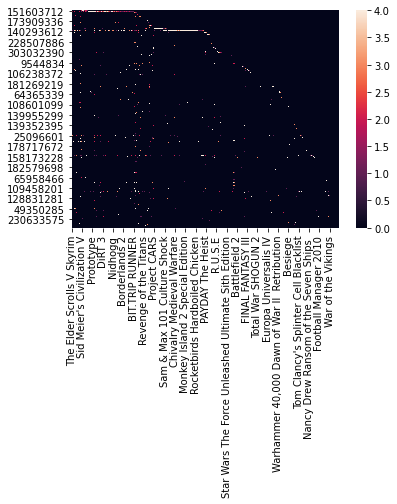

In [25]:
# Create score_df
score_df = pd.DataFrame(np.zeros((len(user_df.index),len(game_df.index))),
                           index = user_df.index,
                           columns = game_df.index)
# score_df.head()
with timer('score'):
    for game in game_df.index:
    
        p025 = game_df.loc[game,'playtime_p025']
        p050 = game_df.loc[game,'playtime_p050']
        p075 = game_df.loc[game,'playtime_p075']
        
        playtimes = playtime_df.loc[:,game]
        scores = 4*np.ones(len(playtimes))
        scores[playtimes - p075<0] = 3
        scores[playtimes - p050<0] = 2
        scores[playtimes - p025<0] = 1
        scores[playtimes==0.0] = 0
        score_df.loc[:,game] = scores

_ = sns.heatmap(score_df)   

# Exploratory data analysis

Visualize some distributions

- Histogram of total playtime per user
- Histogram of average playtime per game per user (i.e. totalplaytime/number of games for each user)
    - That can be used to separate customer into different categories, e.g. casual vs core-game
- Histogram of total playtime per game
- Histogram of average playtime per game
- Histogram of number of users per game
- Histogram of number of game per user

Make new dataframes:

# Total playtime of users

In [ ]:
fix, ax = plt.subplots(1,2,figsize=[15,5])
plt.sca(ax[0])
sns.histplot(data=user_df,x=user_df['playtime_total'])
plt.title('Histogram of playtime across users, count=number of users')
plt.sca(ax[1])
sns.histplot(data=user_df,x=np.log10(user_df['playtime_total']))
plt.title('Histogram of log10(playtime) across users, count=number of users')

### Breakdown of this plot

[WIP] should be done on the whole dataset

# Which user has the most playtime?

In [ ]:
temp = user_df.sort_values('playtime_total',ascending=False).iloc[:5]
sns.barplot(data=temp,x=temp.index,y='playtime_total',order=temp.index)
biggest_gamers_list = temp.index

## What are the favorite games of these users?

In [ ]:
temp = playtime_df.loc[biggest_gamers_list]

fig, ax = plt.subplots(1,5,figsize=[15,5],sharey=True)
for i, user in enumerate(temp.index):
    plt.sca(ax[i])
#     sns.barplot(data=temp.loc[user].sort_values(ascending=False)[:5])
    data=temp.loc[user].sort_values(ascending=False)[:5].plot.bar()
    plt.title(f'user: {user}')
# sns.catplot(kind='bar',data=temp)

### Breakdown

We can already identify several profiles among gamers with high total playtime. Some play a single game for a lot of time, while others play many games for a shorter duration. The biggest playtimes (>1000 hours) are for online competitive games such as *Team Fortress 2* or *Dota 2*. Gamers who divide their time amongst many title (with <100 hours) tend to play single player games.

In [ ]:
temp.loc[user].sort_values(ascending=False)[:5]

# Explore games

## Most owned and longest played games

In [ ]:
game_df.head()

In [ ]:
# game_df['num_user'].sort_values(ascending=False)[:5].plot.bar()

fig, ax = plt.subplots(1,3,figsize=[12,5])
plt.sca(ax[0])
temp = pd.DataFrame(game_df['num_user'].sort_values(ascending=False)[:5])
sns.barplot(data=temp,y=temp.index, x='num_user')
plt.title('number of owned games')
plt.sca(ax[1])
temp = pd.DataFrame(game_df['playtime_total'].sort_values(ascending=False)[:5])
sns.barplot(data=temp,y=temp.index, x='playtime_total')
plt.title('total playtime')
plt.sca(ax[2])
temp = pd.DataFrame((game_df['playtime_total']/game_df['num_user']).sort_values(ascending=False)[:5])
plt.title('average playtime (playtime_total/num_user)')
sns.barplot(data=temp,y=temp.index, x=0)

### Breakdown